In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

MEMORY = 4*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

2023-02-28 14:46:16.253150: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-28 14:46:16.416651: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-28 14:46:17.153828: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /end/home/rh2310/lib:/end/soft/Linux_2.6_64/lib::/end/home/rh2310/.conda/envs/tensorflo

1 Physical GPUs, 1 Logical GPUs


2023-02-28 14:46:18.697364: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-28 14:46:19.236486: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4096 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:65:00.0, compute capability: 8.6


In [2]:
from local_utils import *

In [3]:
import pandas as pd
df_params = pd.read_pickle("../../bacterialcolony_dataset3/turing_df_circuit2_variant1_1000000parametersets.pkl")

In [4]:
df_params.head()

,DA,DB,bA,bB,bC,bD,bE,bF,VA,VB,...,nfe,nee,neb,nce,ss_n,ss_list,ss_class,system_class,maxeig,complex_dispersion
404,1.0,0.001,0.01,0.01,0.01,0.01,0.01,0.01,615.268976,73.210081,...,4.0,4.0,4.0,1.0,2.0,"[0.1997, 0.039, 10.9848, 104.771, 244.7529, 3....",stable spiral,turing I oscillatory,0.004898+0.036487j,True
2726,1.0,0.001,0.01,0.01,0.01,0.01,0.01,0.01,228.017071,94.502643,...,4.0,4.0,4.0,1.0,2.0,"[83.3645, 0.276, 12736.8586, 66.0485, 579.5646...",stable spiral,turing I oscillatory,0.000114+0.002647j,True
3508,1.0,0.001,0.01,0.01,0.01,0.01,0.01,0.01,23.538028,320.885489,...,4.0,4.0,4.0,1.0,3.0,"[6.9465, 0.1825, 57.5198, 3.3825, 131.0374, 1....",stable spiral,turing I oscillatory,0.001639+0.132134j,True
7516,1.0,0.001,0.01,0.01,0.01,0.01,0.01,0.01,16.205693,83.166774,...,4.0,4.0,4.0,1.0,1.0,"[1.7525, 0.2247, 908.552, 10.6864, 225.1614, 2...",stable spiral,turing I oscillatory,0.000652+0.003066j,True
7883,1.0,0.001,0.01,0.01,0.01,0.01,0.01,0.01,85.164519,738.495294,...,4.0,4.0,4.0,1.0,2.0,"[2.8165, 0.0136, 82.5102, 2.7508, 154.2711, 3....",stable spiral,turing I oscillatory,0.001346+0.016362j,True


In [5]:
import pickle

with open('../../bacterialcolony_dataset3/2Dfinal_circuit2_variant1_bc1.7_ca_ID546780_L8_J160_T125_N2500.pkl', 'rb') as f:
    ds_1 = pickle.load(f)
    
with open('../../bacterialcolony_dataset/caMask_seed1_pdivision0.5_L10_J150_T120_N1200.pkl', 'rb') as f:
    mask = pickle.load(f)


In [6]:
ID = 546780
L = 8
data = np.array(ds_1)[:, :, :, np.newaxis]
nodes_n = data.shape[0]
node_names = ["A", "B", "C", "D", "E", "F"]
x_size = data.shape[1]
y_size = data.shape[2]
T=1
indices_all = np.arange(0, x_size*y_size*T, 1).reshape((T, x_size,y_size))
dxdy = x_size*y_size/L**2
N = x_size*y_size    
t_star = np.arange(0, T)

##########################
# select a subset of data
#t_star = t_star[-4:]
#T = len(t_star)
#data = data[:, :, :, -4::]

x_slice = slice(65, 100, 1)
y_slice = slice(65, 100, 1)

#data = data[:, x_slice, y_slice, np.newaxis]
#x_size = data.shape[1]
#y_size = data.shape[2]
#T = 1#data.shape[3]



indices_sub = indices_all[:, x_slice, y_slice]
block_x = indices_sub.shape[1]
block_y = indices_sub.shape[2]
block_size = indices_sub.shape[1]*indices_sub.shape[2]


maxs = np.array([np.max(data[i, :, :, :]) for i in range(data.shape[0])])
mins = np.array([np.min(data[i, :, :, :]) for i in range(data.shape[0])])



In [7]:
df_params.loc[ID,:]

DA                                                                  1.0
DB                                                                0.001
bA                                                                 0.01
bB                                                                 0.01
bC                                                                 0.01
bD                                                                 0.01
bE                                                                 0.01
bF                                                                 0.01
VA                                                            46.733347
VB                                                           134.697819
VC                                                            53.677758
VD                                                            44.231763
VE                                                            943.26562
VF                                                           605

In [8]:
def create_dataset_multi_nodes(
    data,
    t_star,
    N,
    T,
    L,
    training_data_size,
    pde_data_size,    
    signal_to_noise=0,
    shuffle=True,
    derivatives=None,
    idx_data=None,
):
    x_size = data.shape[1]
    y_size = data.shape[2]
    x_domain = L * np.linspace(0, 1, x_size)
    y_domain = L * np.linspace(0, 1, y_size)

    X, Y = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
    XX = np.tile(X.flatten(), T)  # N x T
    YY = np.tile(Y.flatten(), T)  # N x T
    TT = np.repeat(t_star[-T:], N)  # T x N

    #UU = np.einsum("cijk->ckij", data[:, :, :, -T:])
    UU = np.einsum("cxyk->ckxy", data[:, :, :, -T:])
    UU = np.array([UU[i, :, :, :].flatten() for i in range(UU.shape[0])])  # c , N x T
    
    if derivatives is not None:
        dds = np.array([[np.einsum("ijk->kij", d[i, :, :, -T:]).flatten() for d in derivatives]
               for i in range(derivatives[0].shape[0])
              ])                  
    ##########################################
    # Including noise
    if signal_to_noise > 0:
        signal_amp_u = (np.max(UU) - np.min(UU)) / 2.0
        sigma_u = signal_amp_u * signal_to_noise
    # Observed data
    if idx_data is None:
        if shuffle:
            idx_data = np.random.choice(N * T, training_data_size, replace=False)
        else:
            idx_data = list(range(training_data_size))
    # PDE colocations
    if shuffle:
        idx_pde = np.random.choice(N * T, pde_data_size, replace=False)
    else:
        idx_pde = list(range(pde_data_size))

    # Lower/Upper bounds
    lb, ub = lower_upper_bounds(np.c_[XX, YY, TT])
    if derivatives is not None:
        derivatives_lb_ub = [
            lower_upper_bounds(dd.T) for dd in dds
        ]        

    ret = {
        "obs_input": np.c_[XX[idx_data], YY[idx_data], TT[idx_data]],
        "obs_output": np.vstack([UU[i, idx_data] for i in range(UU.shape[0])]).T,
        "pde": np.c_[XX[idx_pde], YY[idx_pde], TT[idx_pde]],
        "lb": lb,
        "ub": ub,
    }
    if derivatives is not None:
        ret = {
            **ret,
            **{
                "ders": dds[:, :, idx_data],
                "derivatives_lb_ub": derivatives_lb_ub,
            },
        }
    if signal_to_noise > 0:
        ret["obs_output"] += sigma_u * np.random.randn(len(idx_data))

    return ret

In [9]:
data.shape

(6, 160, 160, 1)

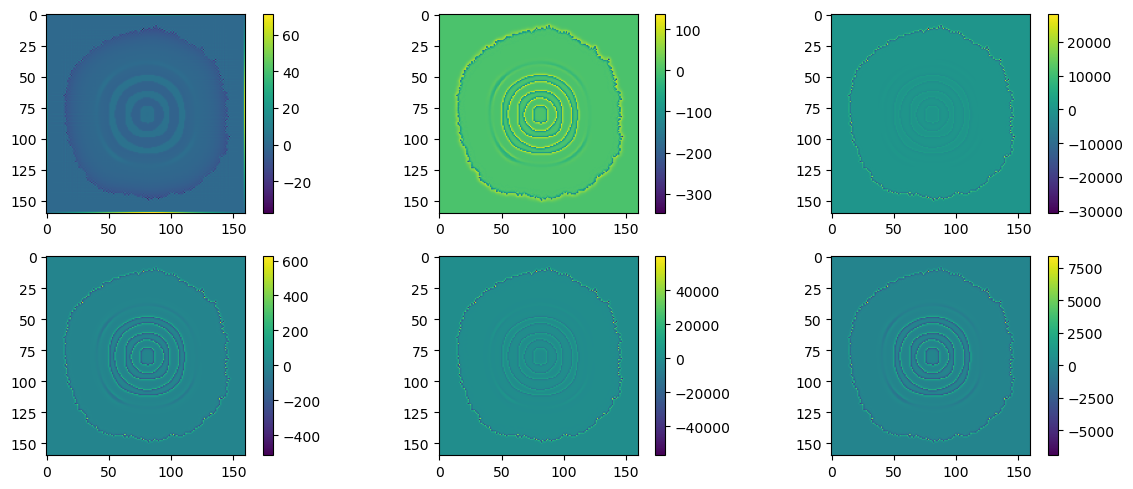

In [10]:
c_xx =  np.array([[ dxdy  * second_order_derivatives((x_size,y_size), data[c, ..., t])[0] 
                        for t in range(data.shape[3])]
                        for c in range(data.shape[0])
                       ])
c_xx = np.einsum("ctij -> cijt", c_xx)
c_yy = np.array([[ dxdy * second_order_derivatives((x_size,y_size), data[c, ..., t])[1] 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_yy = np.einsum("ctij -> cijt", c_yy)

# c_t = np.array([[(data_time[c, ..., t+1] -  data_time[c, ..., t])/(t_star_time[t+1] - t_star_time[t])
#                     for t in range(data.shape[3])]
#                     for c in range(data.shape[0])
#                    ])
# c_t = np.einsum("ctij -> cijt", c_t)

plt.figure(figsize=(12, 5))
for i in range(6):
    plt.subplot(2,3, i+1)
    plt.imshow((c_xx[i,:, : , -1] + c_yy[i,:, : , -1]))
    plt.colorbar()
plt.tight_layout();plt.show()


In [11]:
c_xx.shape

(6, 160, 160, 1)

In [12]:
data.shape

(6, 160, 160, 1)

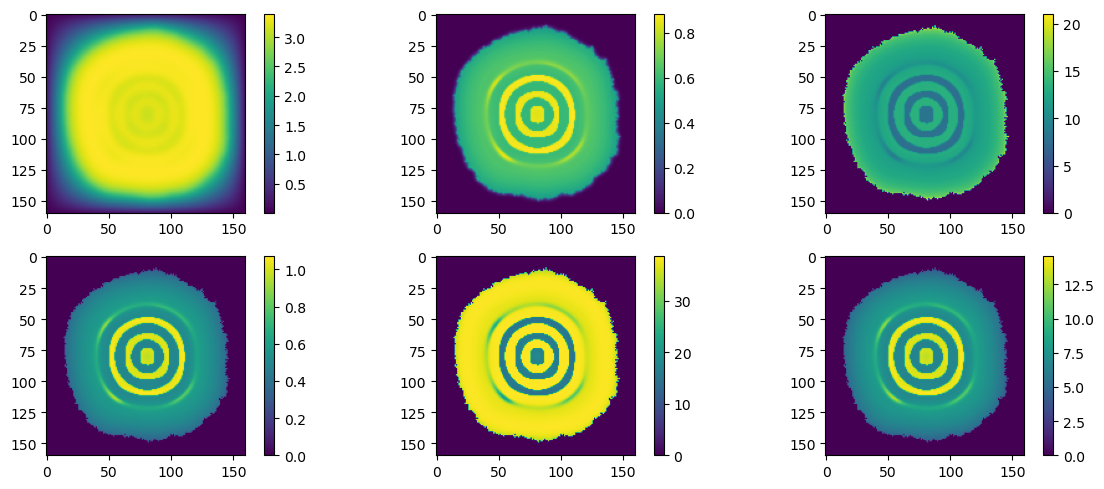

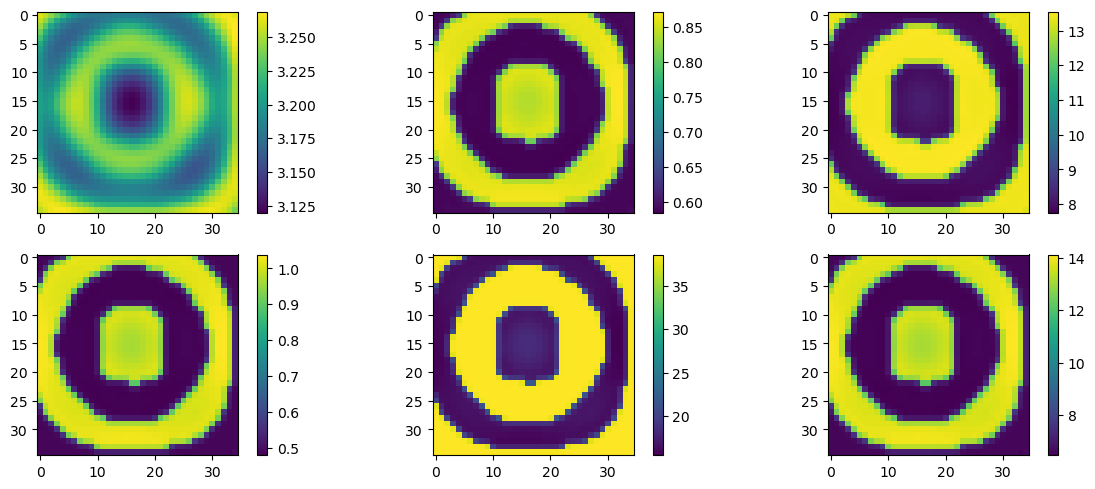

In [13]:
A = data[0, :, :, -1]
B = data[1, :, :, -1]
C = data[2, :, :, -1]
D = data[3, :, :, -1]
E = data[4, :, :, -1]
F = data[5, :, :, -1]

def activate(x, km, n=2):
    act = 1 / (1 + (km / (x + 1e-20)) ** (n))
    return act

def inhibit(x, km, n=2):
    inh = 1 / (1 + (x / (km + 1e-20)) ** (n))
    return inh

params = df_params.loc[ID, :]
DA = params.DA    
DB = params.DB
bA = params.bA
bB = params.bB
bC = params.bC
bD = params.bD
bE = params.bE
bF = params.bF
VA = params.VA
VB = params.VB
VC = params.VC
VD = params.VD
VE = params.VE
VF = params.VF
Kab = params.Kab
Kbd = params.Kbd
Kce = params.Kce
Kda = params.Kda
Keb = params.Keb
Kee = params.Kee
Kfe = params.Kfe
muASV = params.muASV
muLVA = params.muLVA
nab = params.nab
nbd = params.nbd
nce = params.nce
nda = params.nda
nfe = params.nfe
neb = params.neb
nee = params.nee

A_rhs = DA * (c_xx[0, :, :, 0] + c_yy[0, :, :, 0])# - u_t
B_rhs = DB * (c_xx[1, :, :, 0] + c_yy[1, :, :, 0])# - v_t

f_A =  - bA - VA * inhibit(D, Kda, nda) + muASV * A - A_rhs
f_B =  - bB - VB * activate(A, Kab, nab) * inhibit(E, Keb, neb) + muASV * B - B_rhs
f_C =  - bC - VC * inhibit(D, Kda, nda) + muLVA * C
f_D =  - bD - VD * activate(B, Kbd, nbd) + muLVA * D
f_E =  - bE - VE * inhibit(C, Kce, nce) * inhibit(F, Kfe, nfe) * activate(E, Kee, nee) + muLVA * E
f_F =  - bF - VF * activate(B, Kbd, nbd) + muLVA * F

c_t = np.stack([f_A, f_B, f_C, f_D, f_E, f_F])[:,:,:, np.newaxis]

plt.figure(figsize=(12, 5))
for i in range(6):
    plt.subplot(2,3, i+1)
    plt.imshow(data[i, :, :, -1])
    plt.colorbar()
plt.tight_layout();plt.show()
plt.figure(figsize=(12, 5))
for i in range(6):
    plt.subplot(2,3, i+1)
    plt.imshow(data[i, x_slice, y_slice, -1])
    plt.colorbar()
plt.tight_layout();plt.show()

In [14]:
c_xx.shape

(6, 160, 160, 1)

In [15]:
c_restricted = data[:, x_slice, y_slice, :].copy()
c_xx_restricted = c_xx[:, x_slice, y_slice, :].copy()
c_yy_restricted = c_yy[:, x_slice, y_slice, :].copy() 
c_t_restricted = c_t[:, x_slice, y_slice, :].copy()

    
model_params = {'training_data_size': x_size*y_size*T,
                'pde_data_size': x_size*y_size*T,
                'derivatives':[c_xx, c_yy, c_t], 
                'signal_to_noise':0.0,
                'shuffle':False,
                'idx_data':indices_sub.flatten()}


dataset = create_dataset_multi_nodes(data, t_star, N, 1, L, **model_params)
lb = dataset['lb'][0:2]
ub = dataset['ub'][0:2]
obs_X = np.float32(dataset['obs_input'][:, 0:2])
obs_Y = np.float32(dataset['obs_output'])
#pde_X = np.float32(dataset['pde'])
ders_xx = np.float32(dataset['ders'][:, 0, :])
ders_yy = np.float32(dataset['ders'][:, 1, :])
ders_t = np.float32(dataset['ders'][:, 2, :])

In [16]:
A.shape

(160, 160)

In [17]:
obs_X.shape

(1225, 2)

In [18]:
4225/65

65.0

In [19]:
def gen_series():    
    
    for i in range(obs_X.shape[0]):        
        yield obs_X[i,:], obs_Y[i,:], ders_xx[:, i], ders_yy[:, i], ders_t[:, i]    
        
ds = tf.data.Dataset.from_generator(gen_series,
                                    output_types=(tf.float32, tf.float32, tf.float32, tf.float32, tf.float32), 
                                    output_shapes=((obs_X.shape[1],),(obs_Y.shape[1],),
                                                   (ders_xx.shape[0],),(ders_yy.shape[0],),
                                                   (ders_t.shape[0],)))

In [79]:
def clip_by_value_zero_lb(z):
        return tf.clip_by_value(z, 0, 1e10,)
    
class tf_param:
    def __init__(self, name, value=None, is_constant=True):
        self.name = name
        self.value = df_params.loc[ID,:][name]
        if value is None:
            self.value = df_params.loc[ID,:][name]
        else:
            self.value = value
        self.is_constant = is_constant    
    

def create_pinn(layers=[2, 128, 128, 6],
                w1=1, w2=1, w3=1, w4=1, w5=100, w6=100,w7=1,w8=1,
                DA_val=tf_param("DA"), DB_val=tf_param("DB"),
                bA_val=tf_param("bA"),bB_val=tf_param("bB"),bC_val=tf_param("bC"),
                bD_val=tf_param("bD"),bE_val=tf_param("bE"),bF_val=tf_param("bF"),
                VA_val=tf_param("VA"),VB_val=tf_param("VB"),VC_val=tf_param("VC"),
                VD_val=tf_param("VD"),VE_val=tf_param("VE"),VF_val=tf_param("VF"),
                Kab_val=tf_param("Kab"),Kbd_val=tf_param("Kbd"),Kce_val=tf_param("Kce"),
                Kda_val=tf_param("Kda"),Keb_val=tf_param("Keb"),Kee_val=tf_param("Kee"),
                Kfe_val=tf_param("Kfe"),muASV_val=tf_param("muASV"),muLVA_val=tf_param("muLVA"),
                nab_val=tf_param("nab"),nbd_val=tf_param("nbd"),nce_val=tf_param("nce"),
                nda_val=tf_param("nda"),nfe_val=tf_param("nfe"),neb_val=tf_param("neb"),
                nee_val=tf_param("nee")):    
    #lb = tf.constant([x_range[0], y_range[0], pattern.t_star[0]], dtype=tf.float32)
    #ub =  tf.constant([x_range[-1], y_range[-1], pattern.t_star[-1]], dtype=tf.float32)
    pinn = tu.NN_Scaled(layers, lb, ub, tf.float32)
    #optimizer=keras.optimizers.Adam(learning_rate=1e-2)   
    optimizer=keras.optimizers.Adam(learning_rate=5e-2)
    
    def create_tf_var(param, no_clip=False):
        print(f"{param.name}: {param.value}")
        if no_clip:
            return tf.Variable(param.value,
                               dtype=pinn.dtype,
                               name=param.name)
        else:
            return tf.Variable(param.value,
                               dtype=pinn.dtype,
                               name=param.name,
                               constraint=clip_by_value_zero_lb)
    
    DA = create_tf_var(DA_val)    
    DB = create_tf_var(DB_val)
    bA = create_tf_var(bA_val)#
    bB = create_tf_var(bB_val)#
    bC = create_tf_var(bC_val)#
    bD = create_tf_var(bD_val)#
    bE = create_tf_var(bE_val)#
    bF = create_tf_var(bF_val)#
    VA = create_tf_var(VA_val)
    VB = create_tf_var(VB_val)
    VC = create_tf_var(VC_val)
    VD = create_tf_var(VD_val)
    VE = create_tf_var(VE_val)
    VF = create_tf_var(VF_val)
    Kab = create_tf_var(Kab_val)
    Kbd = create_tf_var(Kbd_val)
    Kce = create_tf_var(Kce_val)
    Kda = create_tf_var(Kda_val)
    Keb = create_tf_var(Keb_val)
    Kee = create_tf_var(Kee_val)
    Kfe = create_tf_var(Kfe_val)
    muASV = create_tf_var(muASV_val)
    muLVA = create_tf_var(muLVA_val)
    nab = create_tf_var(nab_val)
    nbd = create_tf_var(nbd_val)
    nce = create_tf_var(nce_val)
    nda = create_tf_var(nda_val)
    nfe = create_tf_var(nfe_val)
    neb = create_tf_var(neb_val)
    nee = create_tf_var(nee_val)
                    
    w1 = tf.Variable(w1,dtype=pinn.dtype,name="w1")
    w2 = tf.Variable(w2,dtype=pinn.dtype,name="w2")
    w3 = tf.Variable(w3,dtype=pinn.dtype,name="w3")
    w4 = tf.Variable(w4,dtype=pinn.dtype,name="w4")
    w5 = tf.Variable(w5,dtype=pinn.dtype,name="w5")
    w6 = tf.Variable(w6,dtype=pinn.dtype,name="w6")
    w7 = tf.Variable(w7,dtype=pinn.dtype,name="w7")
    w8 = tf.Variable(w8,dtype=pinn.dtype,name="w8")
                        
    def as_tuple(val, param):
        if val.is_constant:
            return ()
        else:
            return (param,)
    
    
    params_trainable =(
                      as_tuple(DA_val, DA)
                    + as_tuple(DB_val, DB)
                    + as_tuple(bA_val, bA)
                    + as_tuple(bB_val, bB)
                    + as_tuple(bC_val, bC)
                    + as_tuple(bD_val, bD)
                    + as_tuple(bE_val, bE)
                    + as_tuple(bF_val, bF)
                    + as_tuple(VA_val, VA)
                    + as_tuple(VB_val, VB)
                    + as_tuple(VC_val, VC)
                    + as_tuple(VD_val, VD)
                    + as_tuple(VE_val, VE)
                    + as_tuple(VF_val, VF)
                    + as_tuple(Kab_val, Kab)
                    + as_tuple(Kbd_val, Kbd)
                    + as_tuple(Kce_val, Kce)
                    + as_tuple(Kda_val, Kda)
                    + as_tuple(Keb_val, Keb)
                    + as_tuple(Kee_val, Kee)
                    + as_tuple(Kfe_val, Kfe)
                    + as_tuple(muASV_val, muASV)
                    + as_tuple(muLVA_val, muLVA)
                    + as_tuple(nab_val, nab)
                    + as_tuple(nbd_val, nbd)
                    + as_tuple(nce_val, nce)
                    + as_tuple(nda_val, nda)
                    + as_tuple(nfe_val, nfe)
                    + as_tuple(neb_val, neb)
                    + as_tuple(nee_val, nee)
                   )

    @tf.function
    def train_step_inverse(elements):
        with tf.GradientTape(persistent=True) as tape: 
            H = elements[0]
            tape.watch(H)
            trainables = pinn.trainable_variables + params_trainable


            with tf.GradientTape(persistent=True) as tape2:             
                tape2.watch(H)

                outputs = pinn.net(H)
                Ag = tf.squeeze(outputs[:, 0])
                Bg = tf.squeeze(outputs[:, 1])
#                 Cg = tf.squeeze(outputs[:, 2])
#                 Dg = tf.squeeze(outputs[:, 3])
#                 Eg = tf.squeeze(outputs[:, 4])
#                 Fg = tf.squeeze(outputs[:, 5])

                grad_A = tape2.gradient(Ag, H)
                A_x = grad_A[:, 0]
                A_y = grad_A[:, 1]

                grad_B = tape2.gradient(Bg, H)
                B_x = grad_B[:, 0]
                B_y = grad_B[:, 1]


            grad_A_x = tape.gradient(A_x, H)
            A_xx = grad_A_x[:, 0]
            grad_A_y = tape.gradient(A_y, H)
            A_yy = grad_A_y[:, 1]
            grad_B_x = tape.gradient(B_x, H)
            B_xx = grad_B_x[:, 0]
            grad_B_y = tape.gradient(B_y, H)
            B_yy = grad_B_y[:, 1]

            A = tf.squeeze(elements[1][:, 0])
            B = tf.squeeze(elements[1][:, 1])
            C = tf.squeeze(elements[1][:, 2])
            D = tf.squeeze(elements[1][:, 3])
            E = tf.squeeze(elements[1][:, 4])
            F = tf.squeeze(elements[1][:, 5]) 

            act_A_xx = elements[2][:, 0]
            act_B_xx = elements[2][:, 1]
            act_A_yy = elements[3][:, 0]
            act_B_yy = elements[3][:, 1]

    #         act_A_t = elements[4][:, 0]
    #         act_B_t = elements[4][:, 1]
    #         act_C_t = elements[4][:, 2]
    #         act_D_t = elements[4][:, 3]
    #         act_E_t = elements[4][:, 4]
    #         act_F_t = elements[4][:, 5]            

            def activate(x, km, n=2):
                act = 1 / (1 + (km / (x + 1e-20)) ** (n))
                return act

            def inhibit(x, km, n=2):
                inh = 1 / (1 + (x / (km + 1e-20)) ** (n))
                return inh

            A_rhs = DA * (A_xx + A_yy)# - u_t
            B_rhs = DB * (B_xx + B_yy)# - v_t

            f_A =  -bA -VA * inhibit(D, Kda, nda) + muASV * A - A_rhs
            f_B =  -bB -VB * activate(A, Kab, nab) * inhibit(E, Keb, neb) + muASV * B - B_rhs
            f_C =  -bC -VC * inhibit(D, Kda, nda) + muLVA * C
            f_D =  -bD -VD * activate(B, Kbd, nbd) + muLVA * D
            f_E =  -bE -VE * inhibit(C, Kce, nce) * inhibit(F, Kfe, nfe) * activate(E, Kee, nee) + muLVA * E
            f_F =  -bF -VF * activate(B, Kbd, nbd) + muLVA * F
    #         f_C =  -act_C_t - bC - VC * inhibit(D, Kda, nda) + muLVA * C
    #         f_D =  -act_D_t - bD - VD * activate(B, Kbd, nbd) + muLVA * D
    #         f_E =  -act_E_t - bE - VE * inhibit(C, Kce, nce) * inhibit(F, Kfe, nfe) * activate(E, Kee, nee) + muLVA * E
    #         f_F =  -act_F_t - bF - VF * activate(B, Kbd, nbd) + muLVA * F

            l2_res_A = tf.reduce_sum(f_A**2)
            l2_res_B = tf.reduce_sum(f_B**2)
            l2_res_C = tf.reduce_sum(f_C**2)
            l2_res_D = tf.reduce_sum(f_D**2)
            l2_res_E = tf.reduce_sum(f_E**2)
            l2_res_F = tf.reduce_sum(f_F**2)

            act_A_rhs = DA*(act_A_xx + act_A_yy) #- act_A_t
            act_B_rhs = DB*(act_B_xx + act_B_yy) #- act_B_t

            l2_res_A_rhs = tf.reduce_sum((A_rhs-act_A_rhs)**2)
            l2_res_B_rhs = tf.reduce_sum((B_rhs-act_B_rhs)**2)


            l2 = (w1*l2_res_A + w2*l2_res_B + w3*l2_res_C + w4*l2_res_D + 
                  w5*l2_res_E + w6*l2_res_F +  
                  w7*l2_res_A_rhs + w8*l2_res_B_rhs)
            #l2 = l2_res_A + l2_res_B  + l2_res_A_rhs + l2_res_B_rhs
            # l2 = l2_res_A_rhs + l2_res_B_rhs

        grads = tape.gradient(l2, trainables)
        optimizer.apply_gradients(zip(grads, trainables))
        return (l2_res_A, l2_res_B, l2_res_C, l2_res_D, l2_res_E, l2_res_F,  
                l2_res_A_rhs, l2_res_B_rhs)
    
    names = ['l2_res_A', 'l2_res_B', 'l2_res_C', 'l2_res_D', 'l2_res_E', 'l2_res_F',  
            'l2_res_A_rhs', 'l2_res_B_rhs']

    def print_callback(printer, losses, epoch):

        printer(f"at epoch {epoch:d}, total loss: {np.sum(losses)}")
        printer(", ".join([f"{n}: {v:.8f}" for n,v in zip(names, losses)]))         
        printer(", ".join([f"{par.name}: {par.numpy()}" for par in params_trainable]))
    
    return (pinn, optimizer, train_step_inverse,params_trainable, names, print_callback,
            w1, w2, w3, w4, w5, w6, w7, w8)

In [80]:
(pinn1, optimizer1, train_step_inverse1,params_trainable1,names, print_callback1,
w1, w2, w3, w4, w5, w6, w7, w8) = create_pinn(
bA_val=tf_param("bA", 0, False),bB_val=tf_param("bB", 0, False),bC_val=tf_param("bC", 0, False),
bD_val=tf_param("bD", 0, False),bE_val=tf_param("bE", 0, False),bF_val=tf_param("bF", 0, False),
VA_val=tf_param("VA", 0, False),VB_val=tf_param("VB", 0, False),VC_val=tf_param("VC", 0, False),
VD_val=tf_param("VD", 0, False),VE_val=tf_param("VE", 0, False),VF_val=tf_param("VF", 0, False),
w1=1, w2=1, w3=1, w4=1, w5=100, w6=100, w7=1000, w8=1000
)

(bA, bB, bC, bD, bE, bF, VA, VB, VC, VD, VE, VF) = params_trainable1

DA: 1.0
DB: 0.001
bA: 0
bB: 0
bC: 0
bD: 0
bE: 0
bF: 0
VA: 0
VB: 0
VC: 0
VD: 0
VE: 0
VF: 0
Kab: 112.03598370729861
Kbd: 4.693803436565611
Kce: 0.9930030959145896
Kda: 0.2699281477606056
Keb: 45.269302324109745
Kee: 0.563496304565512
Kfe: 10.08286680374087
muASV: 4.247713917996289
muLVA: 1.4288264760159275
nab: 1.0
nbd: 2.0
nce: 1.0
nda: 1.0
nfe: 4.0
neb: 4.0
nee: 4.0


In [81]:
epochs=150000+1
params_est = np.zeros((epochs, 12))

def epoch_callback1(epoch, loss_samples, index):
    params_est[epoch, : ] = (bA.numpy(), bB.numpy(), bC.numpy(), 
                             bD.numpy(), bE.numpy(), bF.numpy(),
                             VA.numpy(), VB.numpy(), VC.numpy(),
                             VD.numpy(), VE.numpy(), VF.numpy())
def stop_condition1(epoch, loss_samples, index):
    (l2_res_A, l2_res_B, l2_res_C, l2_res_D, l2_res_E, l2_res_F,  
                l2_res_A_rhs, l2_res_B_rhs)= loss_samples[index, :]
    if l2_res_C < 1 and l2_res_D < 1 and l2_res_E < 1 and l2_res_F<1:
        return True
    else:
        return False

In [82]:
obs_X.shape

(1225, 2)

In [83]:
losses1 = tu.train(epochs=epochs,
                  batch_size=1225,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 8,
                  print_interval=1000,
                  loss_sample_interval = 1,
                  stop_threshold=1e-5,
                  print_callback = print_callback1,
                  epoch_callback=epoch_callback1,
                  stop_condition=stop_condition1)


Start of epoch 0
at epoch 0, total loss: 3024962.192103386
l2_res_A: 227724.46875000, l2_res_B: 12052.00585938, l2_res_C: 295466.18750000, l2_res_D: 1571.98376465, l2_res_E: 2186348.00000000, l2_res_F: 289572.56250000, l2_res_A_rhs: 12222.98535156, l2_res_B_rhs: 3.99837780
bA:0: 0.05000115931034088, bB:0: 0.05000116303563118, bC:0: 0.05000116303563118, bD:0: 0.05000115931034088, bE:0: 0.05000115558505058, bF:0: 0.05000115558505058, VA:0: 0.05000115558505058, VB:0: 0.05000115931034088, VC:0: 0.05000115558505058, VD:0: 0.05000115558505058, VE:0: 0.05000115558505058, VF:0: 0.05000116303563118
Time taken: 7.34s

Start of epoch 1000
at epoch 1000, total loss: 343699.8973197937
l2_res_A: 2771.29760742, l2_res_B: 311.55407715, l2_res_C: 8593.34179688, l2_res_D: 33.16793823, l2_res_E: 296951.31250000, l2_res_F: 26871.22851562, l2_res_A_rhs: 8164.04980469, l2_res_B_rhs: 3.94507980
bA:0: 10.409610748291016, bB:0: 2.856674909591675, bC:0: 10.864216804504395, bD:0: 0.5033117532730103, bE:0: 32.55

KeyboardInterrupt: 

In [ ]:
bA  0.01, bB  0.01, bC  0.01, bD  0.01
bE  0.01, bF  0.01, VA  46.733347, VB  134.697819
VC  53.677758, VD  44.231763, VE  943.26562, VF  605.026691

In [75]:
params_estc = params_est.copy()

In [25]:
params_est = params_est[:25436, :]

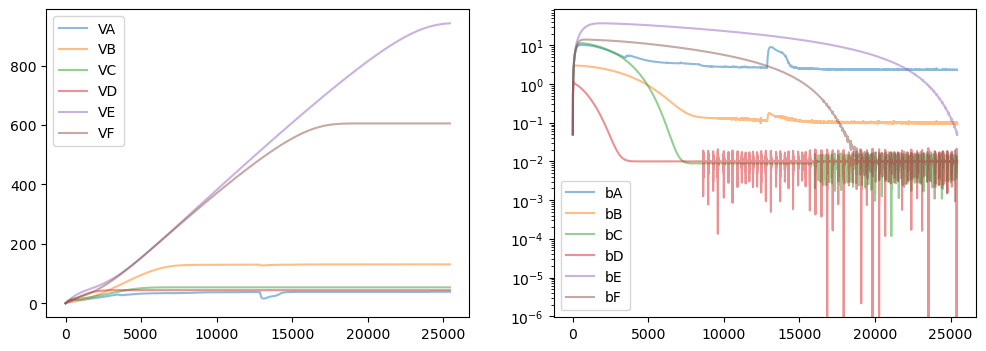

In [26]:
param_name = ["bA", "bB", "bC", "bD", "bE", "bF", "VA", "VB", "VC", "VD", "VE", "VF"]
plt.figure(figsize=(12,4));plt.subplot(121)
for i, n in enumerate(param_name):
    if params_est[-1,i] > 20:
        plt.plot(params_est[:,i], label=n, alpha=.5)
        
plt.legend();
plt.subplot(122)
for i, n in enumerate(param_name):
    if params_est[-1,i] <= 20:
        plt.plot(params_est[:,i], label=n, alpha=.5)
        
plt.legend();plt.yscale('log');plt.show()

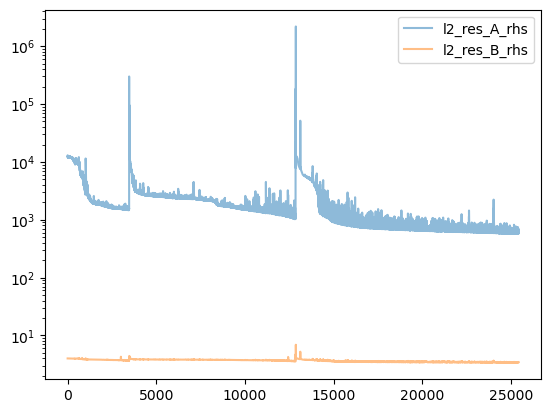

In [27]:
for i, n in enumerate(names[-2:]):
    plt.plot(losses1[:25436,6+i], label=n, alpha=.5)
        
plt.legend()
plt.yscale('log')
plt.show()

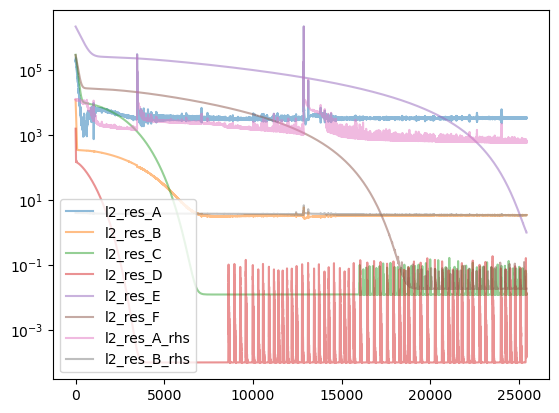

In [28]:
for i, n in enumerate(names):
    plt.plot(losses1[:25436,i], label=n, alpha=.5)
        
plt.legend();plt.yscale('log');plt.show()

In [33]:
optimizer1.lr

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.01>

In [34]:
optimizer1.lr.assign(1e-2)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=0.01>

In [35]:
w1.assign(10.0)
w2.assign(10.0)


<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=10.0>

In [36]:
epochs2=10000+1
params_est2 = np.zeros((epochs2, 12))
def epoch_callback2(epoch, loss_samples, index):
    params_est2[epoch, : ] = (bA.numpy(), bB.numpy(), bC.numpy(), 
                             bD.numpy(), bE.numpy(), bF.numpy(),
                             VA.numpy(), VB.numpy(), VC.numpy(),
                             VD.numpy(), VE.numpy(), VF.numpy())

In [37]:
losses2 = tu.train(epochs=epochs2,
                  batch_size=4225,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 8,
                  print_interval=1000,
                  loss_sample_interval = 1,
                  stop_threshold=1e-5,
                  print_callback = print_callback1,
                  epoch_callback=epoch_callback1)


Start of epoch 0
at epoch 0, total loss: 3921.1208547765855
l2_res_A: 3341.70971680, l2_res_B: 3.46661854, l2_res_C: 0.01244828, l2_res_D: 0.00183662, l2_res_E: 0.98743868, l2_res_F: 0.01876961, l2_res_A_rhs: 571.49536133, l2_res_B_rhs: 3.42866492
bA:0: 2.321204900741577, bB:0: 0.09024220705032349, bC:0: 0.008923719637095928, bD:0: 0.009356509894132614, bE:0: 0.051215995103120804, bF:0: 0.010029168799519539, VA:0: 38.76174545288086, VB:0: 130.94334411621094, VC:0: 53.67409896850586, VD:0: 44.239898681640625, VE:0: 942.0973510742188, VF:0: 605.1433715820312
Time taken: 0.54s

Start of epoch 1000
at epoch 1000, total loss: 3875.6810794127377
l2_res_A: 3308.17138672, l2_res_B: 3.45191622, l2_res_C: 0.01239161, l2_res_D: 0.00010032, l2_res_E: 0.50047004, l2_res_F: 0.01876966, l2_res_A_rhs: 560.11206055, l2_res_B_rhs: 3.41398430
bA:0: 2.298102855682373, bB:0: 0.09622365981340408, bC:0: 0.008834955282509327, bD:0: 0.01000145822763443, bE:0: 0.024989137426018715, bF:0: 0.010027752257883549, 

In [44]:
optimizer1.lr.assign(5e-3)
w1.assign(100.0)
w2.assign(100.0)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=100.0>

In [45]:
epochs3=20000+1
params_est3 = np.zeros((epochs3, 12))
def epoch_callback3(epoch, loss_samples, index):
    params_est3[epoch, : ] = (bA.numpy(), bB.numpy(), bC.numpy(), 
                             bD.numpy(), bE.numpy(), bF.numpy(),
                             VA.numpy(), VB.numpy(), VC.numpy(),
                             VD.numpy(), VE.numpy(), VF.numpy())

In [46]:
losses3 = tu.train(epochs=epochs3,
                  batch_size=4225,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 8,
                  print_interval=1000,
                  loss_sample_interval = 1,
                  stop_threshold=1e-5,
                  print_callback = print_callback1,
                  epoch_callback=epoch_callback3)


Start of epoch 0
at epoch 0, total loss: 3312.1696005676786
l2_res_A: 2829.05468750, l2_res_B: 3.37267423, l2_res_C: 0.01239546, l2_res_D: 0.00017826, l2_res_E: 0.28413525, l2_res_F: 0.01876967, l2_res_A_rhs: 476.03100586, l2_res_B_rhs: 3.39575434
bA:0: 2.2221429347991943, bB:0: 0.09937449544668198, bC:0: 0.008843377232551575, bD:0: 0.01005681324750185, bE:0: 0.0, bF:0: 0.010028595104813576, VA:0: 39.05253982543945, VB:0: 130.90200805664062, VC:0: 53.67402648925781, VD:0: 44.24034881591797, VE:0: 943.3753051757812, VF:0: 605.143310546875
Time taken: 0.67s

Start of epoch 1000
at epoch 1000, total loss: 3298.9537973281112
l2_res_A: 2819.69189453, l2_res_B: 3.37338495, l2_res_C: 0.01239158, l2_res_D: 0.00010032, l2_res_E: 0.28413525, l2_res_F: 0.01876963, l2_res_A_rhs: 472.17938232, l2_res_B_rhs: 3.39373875
bA:0: 2.2194061279296875, bB:0: 0.09905634820461273, bC:0: 0.008835804648697376, bD:0: 0.010001937858760357, bE:0: 0.0, bF:0: 0.010031170211732388, VA:0: 39.05885696411133, VB:0: 130


Start of epoch 15000
at epoch 15000, total loss: 3265.0642142855577
l2_res_A: 2833.13427734, l2_res_B: 3.38646722, l2_res_C: 0.01239291, l2_res_D: 0.00010032, l2_res_E: 0.28413731, l2_res_F: 0.01876988, l2_res_A_rhs: 424.85565186, l2_res_B_rhs: 3.37241745
bA:0: 2.195298910140991, bB:0: 0.09761671721935272, bC:0: 0.008809958584606647, bD:0: 0.010001474060118198, bE:0: 0.0, bF:0: 0.010012629441916943, VA:0: 39.11426544189453, VB:0: 130.9775848388672, VC:0: 53.67399215698242, VD:0: 44.240299224853516, VE:0: 943.3754272460938, VF:0: 605.1434326171875
Time taken: 43.53s

Start of epoch 16000
at epoch 16000, total loss: 3278.4428689251363
l2_res_A: 2848.18286133, l2_res_B: 3.38773727, l2_res_C: 0.01239175, l2_res_D: 0.00010032, l2_res_E: 0.28413525, l2_res_F: 0.01876968, l2_res_A_rhs: 423.18264771, l2_res_B_rhs: 3.37422562
bA:0: 2.1956732273101807, bB:0: 0.09746498614549637, bC:0: 0.008826387114822865, bD:0: 0.01000329852104187, bE:0: 0.0, bF:0: 0.010026746429502964, VA:0: 39.11045074462890

In [ ]:
bA  0.01, bB  0.01, bC  0.01, bD  0.01
bE  0.01, bF  0.01, VA  46.733347, VB  134.697819
VC  53.677758, VD  44.231763, VE  943.26562, VF  605.026691

In [47]:
@tf.function
def grads(pinn, inputs):    
    with tf.GradientTape(persistent=True) as tape:        
        tape.watch(inputs)      
        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(inputs)            
            outputs = pinn.net(inputs)            
        
            Ag = tf.squeeze(outputs[:, 0])
            Bg = tf.squeeze(outputs[:, 1])
            Cg = tf.squeeze(outputs[:, 2])
            Dg = tf.squeeze(outputs[:, 3])
            Eg = tf.squeeze(outputs[:, 4])
            Fg = tf.squeeze(outputs[:, 5])

            grad_A = tape2.gradient(Ag, inputs)
            A_x = grad_A[:, 0]
            A_y = grad_A[:, 1]
            #A_t = grad_A[:, 2]

            grad_B = tape2.gradient(Bg, inputs)
            B_x = grad_B[:, 0]
            B_y = grad_B[:, 1]
            #B_t = grad_B[:, 2]
            
#             grad_C = tape2.gradient(Cg, inputs)
#             C_t = grad_C[:, 2]
            
#             grad_D = tape2.gradient(Dg, inputs)
#             D_t = grad_D[:, 2]
            
#             grad_E = tape2.gradient(Eg, inputs)
#             E_t = grad_E[:, 2]
            
#             grad_F = tape2.gradient(Fg, inputs)
#             F_t = grad_F[:, 2]
            

        grad_A_x = tape.gradient(A_x, inputs)
        A_xx = grad_A_x[:, 0]
        grad_A_y = tape.gradient(A_y, inputs)
        A_yy = grad_A_y[:, 1]
        grad_B_x = tape.gradient(B_x, inputs)
        B_xx = grad_B_x[:, 0]
        grad_B_y = tape.gradient(B_y, inputs)
        B_yy = grad_B_y[:, 1]
    return (tf.squeeze(Ag), tf.squeeze(A_xx), tf.squeeze(A_yy),
            tf.squeeze(Bg), tf.squeeze(B_xx), tf.squeeze(B_yy),
            tf.squeeze(Cg), 
            tf.squeeze(Dg), 
            tf.squeeze(Eg), 
            tf.squeeze(Fg))                               
#     return (tf.squeeze(Ag), tf.squeeze(A_xx), tf.squeeze(A_yy), tf.squeeze(A_t),
#             tf.squeeze(Bg), tf.squeeze(B_xx), tf.squeeze(B_yy), tf.squeeze(B_t),
#             tf.squeeze(Cg), tf.squeeze(C_t),
#             tf.squeeze(Dg), tf.squeeze(D_t),
#             tf.squeeze(Eg), tf.squeeze(E_t),
#             tf.squeeze(Fg), tf.squeeze(F_t))

def to(arr):
    return arr.numpy().reshape(block_x, block_y)

def plot_state(pinn):
        (A, A_xx, A_yy, 
         B, B_xx, B_yy, 
         C,  D,  E,  F, 
        ) = grads(pinn, obs_X)
        
        A_der = DA*( to(A_xx) + to(A_yy))
        B_der = DB*( to(B_xx) + to(B_yy))

        actual_A_der = DA*( c_xx[0,x_slice, y_slice  , -1] + c_yy[0,x_slice, y_slice  , -1])# - to(u_t2)[-1, ...]
        actual_B_der = DB*( c_xx[1,x_slice, y_slice  , -1] + c_yy[1,x_slice, y_slice  , -1])# - to(v_t2)[-1, ...]
        # X and Y are misoriented
        A_der = A_der
        B_der = B_der

        A = c_restricted[0,:, : , -1]
        B = c_restricted[1,:, : , -1]

        
        plot_n_im([to(A_xx), c_xx[0,x_slice, y_slice , -1], to(A_yy), c_yy[0,x_slice, y_slice  , -1]], 
          ["A_xx", "Actual A_xx", "A_yy", "Actual A_yy"],          
          figsize=(12, 3)); plt.tight_layout()

        plot_n_im([to(B_xx), c_xx[1,x_slice, y_slice  , -1], to(B_yy), c_yy[1,x_slice, y_slice  , -1]],
                  ["B_xx", "Actual B_xx", "B_yy", "Actual B_yy"],          
                  figsize=(12, 3)); plt.tight_layout()
#         plot_n_im([to(A_t).T,  c_t[0,:, : , -1],  to(B_t).T,  c_t[1,:, : , -1]],
#                   ["A_t", "Actual A_t", "B_t", "Actual B_t"],          
#                   figsize=(12, 3)); plt.tight_layout()
        plot_n_im([c_t[0,x_slice, y_slice , -1],   c_t[1,x_slice, y_slice, -1]],
                   ["Actual A_t",  "Actual B_t"],          
                   figsize=(12, 3)); plt.tight_layout()
        plot_n_im([A_der,  actual_A_der],
                  ["RHS A", "Actual RHS A"],          
                  figsize=(12, 3)); plt.tight_layout()
        plot_n_im([B_der,  actual_B_der],
                  ["RHS B", "Actual RHS B"],          
                  figsize=(12, 3)); plt.tight_layout()
        plt.show()

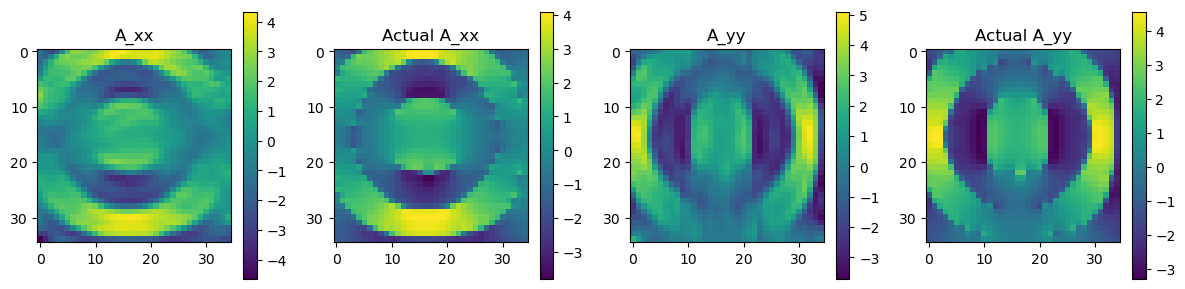

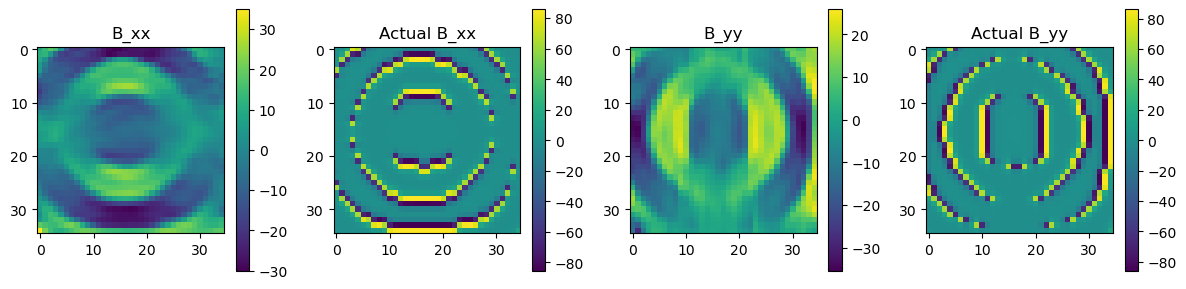

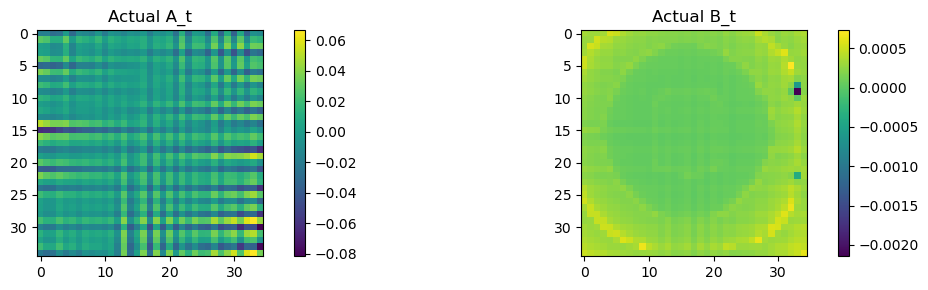

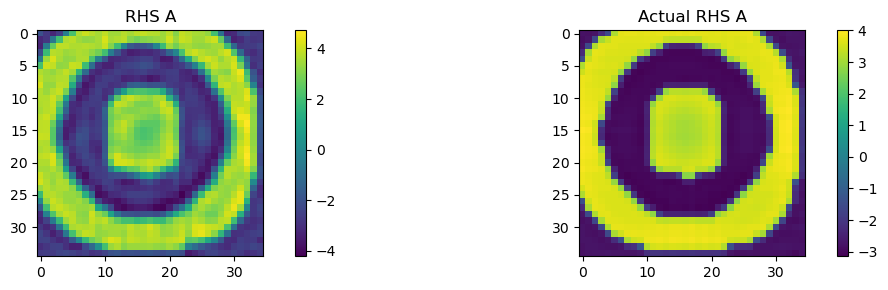

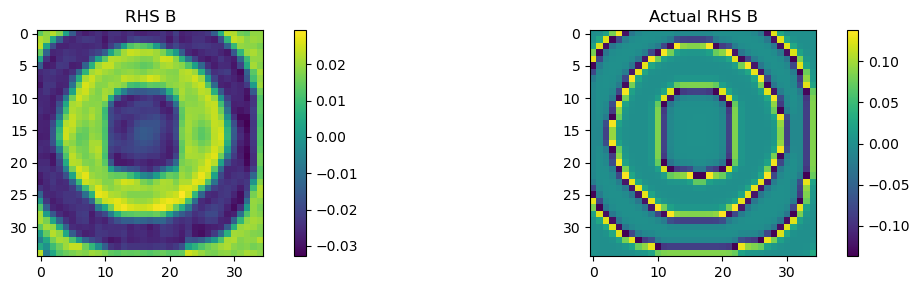

In [49]:
plot_state(pinn1)

3105.5037


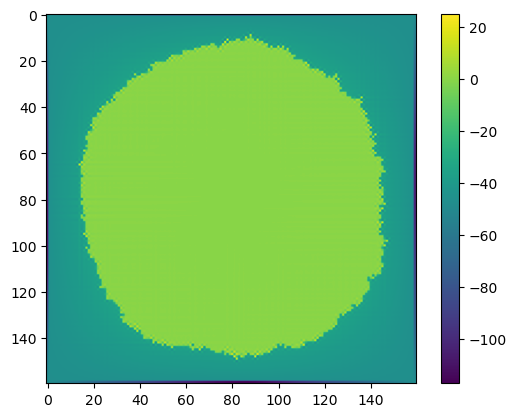

In [192]:
f_Ac = f_A.copy()
#f_Ac[f_Ac < 0] = -100
plt.imshow(f_Ac)
plt.colorbar()
print(np.sum(f_E**2))

In [142]:
(block_x, block_y)

(160, 160)